# BAYESIAN COMMODITY FUTURES INDICES

## Imports

In [1]:
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sbn
import numpy             as np
import pyflux            as pf

from helpers                       import best_of
from itertools                     import product
from pandas.tools.plotting         import autocorrelation_plot
from scipy.stats                   import laplace, t
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.collections        import PolyCollection

## Notebook  Settings

In [2]:
%matplotlib notebook
sbn.set_style('whitegrid')

## Read and Fix Data

In [3]:
dat_file = './data/CommodityIndices.xlsx'
skiprows = (2, 3, 4, 5)
raw_data = pd.read_excel(dat_file, skiprows=skiprows, index_col=0, parse_cols='B:AE')

raw_data.columns = [column[4:-2].rstrip() for column in raw_data.columns]
raw_data.iloc[0] = 100.0

## Index, Returns, and Volatility
Pick any index by name

In [4]:
raw_data.columns.values.tolist()

['Commodity',
 'Energy',
 'Precious Metals',
 'Industrial Metals',
 'Agriculture',
 'Livestock',
 'WTI Crude Oil',
 'Brent Crude',
 'Heat Oil',
 'Unleaded Gas',
 'Natural Gas',
 'Aluminum',
 'Copper',
 'Nickel',
 'Zinc',
 'Gold',
 'Silver',
 'Wheat',
 'Kansas Wheat',
 'Corn',
 'Soybeans',
 'Soybean Oil',
 'Soybean Meal',
 'Cotton',
 'Sugar',
 'Coffee',
 'Cocoa',
 'Live Cattle',
 'Lean Hogs']

<IPython.core.display.Javascript object>


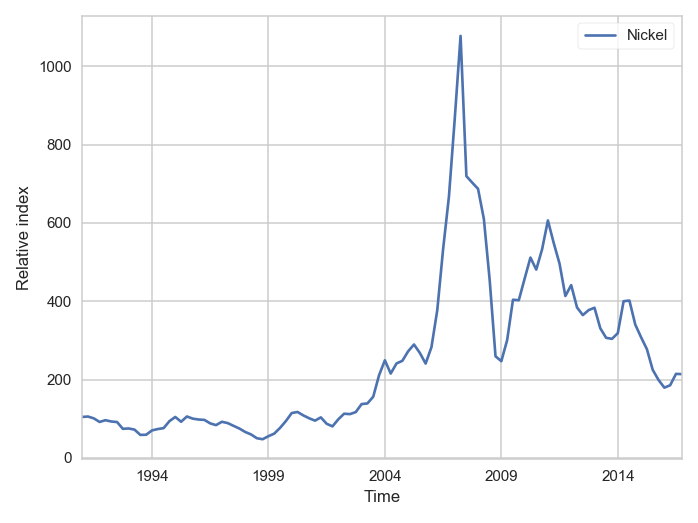

In [5]:
name = 'Nickel'  # Name of index as string

data = raw_data[name].resample('BQ').mean()

fig, ax = plt.subplots(num=name+' Over the Aeons')
data.plot(ax=ax, label=name)

ax.legend(loc='best', frameon=True, fancybox=True, framealpha=0.8)
ax.set_xlabel('Time')
ax.set_ylabel('Relative index')

fig.tight_layout()

Not exactly what you'd call a _stationary_ time series. So, ...

### ... let's look at quarterly returns instead

<IPython.core.display.Javascript object>


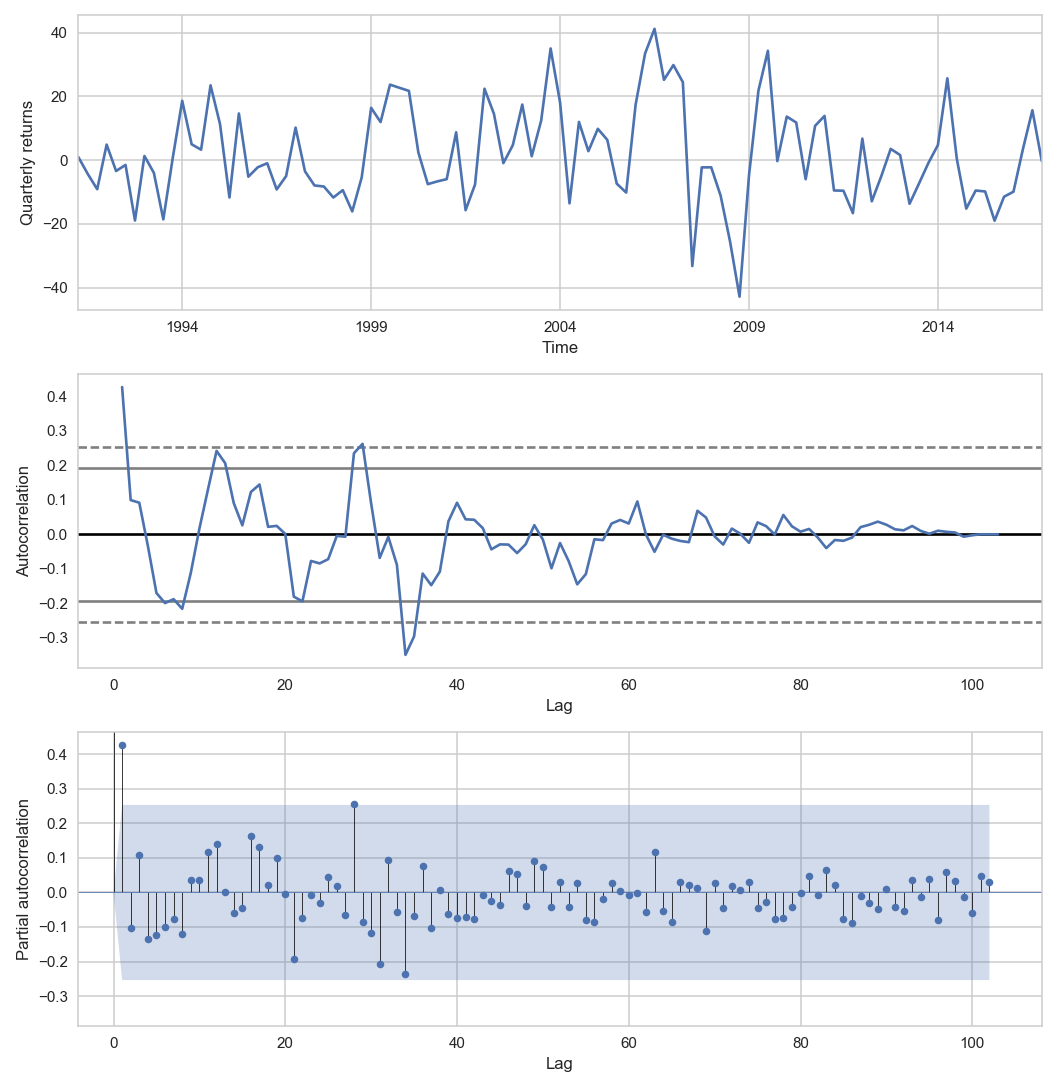

In [6]:
returns = 100 * data.pct_change(1).dropna()

fig = plt.figure(num='Returns on '+name+' and their (Partial) Autocorrelation', figsize=(9.7, 10))
return_ax = fig.add_subplot(311)
aucorr_ax = fig.add_subplot(312)
pacorr_ax = fig.add_subplot(313)

returns.plot(ax=return_ax)
return_ax.set_xlabel('Time')
return_ax.set_ylabel('Quarterly returns')

autocorrelation_plot(returns, ax=aucorr_ax)

plot_pacf(returns, alpha=0.01, ax=pacorr_ax, linewidth=0.5)
pacorr_ax.set_ylim(aucorr_ax.get_ylim())
pacorr_ax.set_xlim(aucorr_ax.get_xlim())
pacorr_ax.set_title('')
pacorr_ax.set_xlabel('Lag')
pacorr_ax.set_ylabel('Partial autocorrelation')

fig.tight_layout()

Not much of an autocorrelation, but maybe something we can pick up in our models.

### Distribution of the returns 

<IPython.core.display.Javascript object>


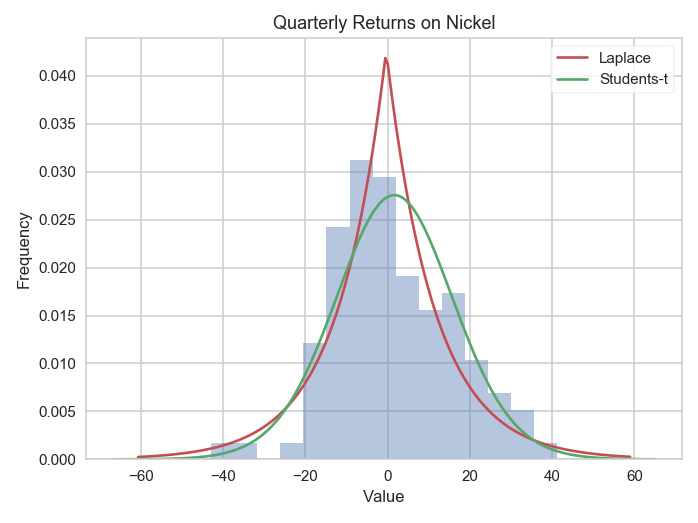

In [9]:
fig, ax = plt.subplots(num='Distribution of Returns on '+name)

sbn.distplot(returns, 
             bins=15, 
             kde=False, 
             fit=laplace, 
             fit_kws={'color': '#c44e52', 'label': 'Laplace'}, 
             ax=ax);
ax.set_title('Quarterly Returns on '+name)
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')

x_lims = ax.get_xlim()
x_vals = np.linspace(*x_lims, 200)
params = t.fit(returns)
ax.plot(x_vals, t.pdf(x_vals, *params), label='Students-t')
ax.legend(loc='best', frameon=True, fancybox=True, framealpha=0.8)

fig.tight_layout()

Note that the tails of the returns are too pronounced for a Gaussian process.

## A Grand Tour of the Bayesian  `PyFlux` Package
In case you are wondering why we never touch the _priors_, it is because they seem to be fine for the data at hand. Nothing could express my belief better. Note also, that we will not consider GARCH-type models here, as these are already dealt with in other notebooks at length.
### ARMA models
#### Set up lag ranges and scan through all models to find the one with minimal BIC

In [10]:
maximumlag = 5  # Up to which lag-order should we test models?

timeseries = returns.values
drop_first = lambda lag_combi: timeseries[maximumlag - max(lag_combi.values()):]
lag_ranges = {'ar': range(maximumlag+1),
              'ma': range(maximumlag+1)}
lag_combis = (dict(zip(lag_ranges.keys(), values)) for values in product(*lag_ranges.values()))
ARMAmodels = (pf.ARIMA(drop_first(lags), **lags, family=pf.t()) for lags in lag_combis)

best_ARMA_model = best_of(ARMAmodels)
best_ARMA_model.fit().summary(transformed=False)

t ARIMA(4,0,4)                                                                                            
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 4                                           Log Likelihood: -373.2865                         
End Date: 101                                           AIC: 768.573                                      
Number of observations: 98                              BIC: 797.0076                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 1.7294     0.059      29.3091  0.0      (1.6138 | 1.8451)        
AR(1)                                

#### Perform Black Box Variational Inference and check its convergence
Consider increasing the number of iterations if you are not happy with what you see

10% done : ELBO is -423.152692839, p(y,z) is -400.083741331, q(z) is 23.0689515073
20% done : ELBO is -418.091652336, p(y,z) is -395.10323408, q(z) is 22.9884182563
30% done : ELBO is -414.899531786, p(y,z) is -391.876461835, q(z) is 23.0230699511
40% done : ELBO is -414.247698592, p(y,z) is -391.279413995, q(z) is 22.968284597
50% done : ELBO is -412.943671898, p(y,z) is -390.081077909, q(z) is 22.8625939889
60% done : ELBO is -413.322179559, p(y,z) is -390.401256405, q(z) is 22.9209231533
70% done : ELBO is -412.298959317, p(y,z) is -389.452455493, q(z) is 22.8465038237
80% done : ELBO is -411.991983663, p(y,z) is -389.266780046, q(z) is 22.7252036173
90% done : ELBO is -412.002105905, p(y,z) is -389.364122059, q(z) is 22.6379838458
100% done : ELBO is -411.807274666, p(y,z) is -389.219572693, q(z) is 22.587701973

Final model ELBO is -411.852390664


<IPython.core.display.Javascript object>


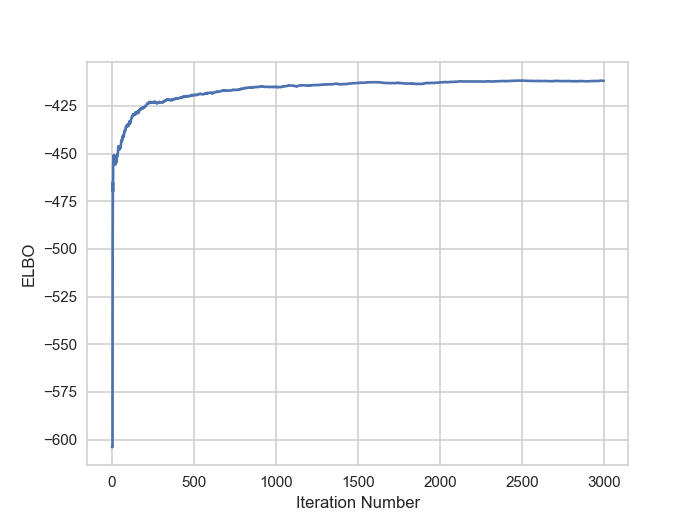

t ARIMA(4,0,4)                                                                                            
======================================================= ==================================================
Dependent Variable: Series                              Method: BBVI                                      
Start Date: 4                                           Unnormalized Log Posterior: -389.3245             
End Date: 101                                           AIC: 800.648907297                                
Number of observations: 98                              BIC: 829.083549563                                
Latent Variable                          Median             Mean               95% Credibility Interval 
======================================== ================== ================== =========================
Constant                                 1.7858             1.7858             (1.6985 | 1.873)         
AR(1)                                    0.

In [11]:
ARMAresults = best_ARMA_model.fit(method='BBVI', map_start=True, record_elbo=True, iterations=3000)

fig, ax = plt.subplots()
ax.plot(ARMAresults.elbo_records)
ax.set_xlabel('Iteration Number')
ax.set_ylabel('ELBO')

ARMAresults.summary(transformed=False)

#### Plot fit to returns and forecast for a year

<IPython.core.display.Javascript object>


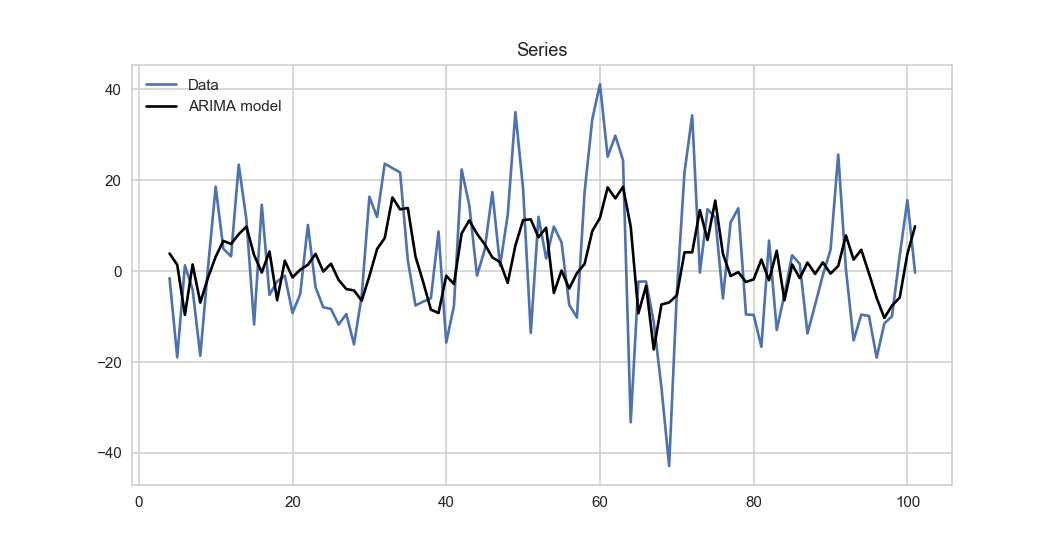

<IPython.core.display.Javascript object>


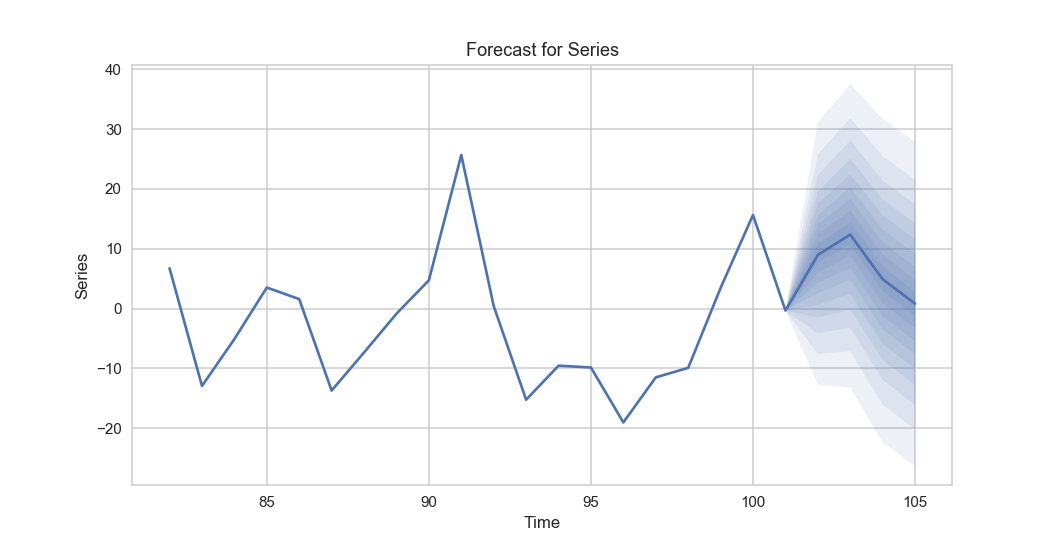

In [12]:
best_ARMA_model.plot_fit(figsize=(9.7, 5))
best_ARMA_model.plot_predict(h=4, figsize=(9.7, 5))
children = plt.gca().get_children() 
_ = [child.set_facecolor('C0') for child in children if isinstance(child, PolyCollection)]

### GAS models on the volatility ...
#### Set up lag ranges and scan through all models to find the one with minimal BIC

In [13]:
maximumlag = 4  # Up to which lag-order should we test models?

timeseries = returns.abs().values
drop_first = lambda lag_combi: timeseries[maximumlag - max(lag_combi.values()):]
lag_ranges = {'ar': range(maximumlag+1),
              'sc': range(maximumlag+1)}
lag_combis = (dict(zip(lag_ranges.keys(), values)) for values in product(*lag_ranges.values()))
GAS_models = (pf.GAS(drop_first(lags), **lags, family=pf.Poisson()) for lags in lag_combis)

best_GAS_model = best_of(GAS_models)
best_GAS_model.fit().summary(transformed=False)

PoissonGAS (0,0,3)                                                                                        
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 3                                           Log Likelihood: -515.0586                         
End Date: 101                                           AIC: 1038.1171                                    
Number of observations: 99                              BIC: 1048.4976                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 2.4484     0.0426     57.4101  0.0      (2.3648 | 2.5319)        
SC(1)                                

#### Sample posterior probability with MCMC
Consider increasing the number of simulated steps if the results are not converged

Acceptance rate of Metropolis-Hastings is 0.293175

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.295525


<IPython.core.display.Javascript object>


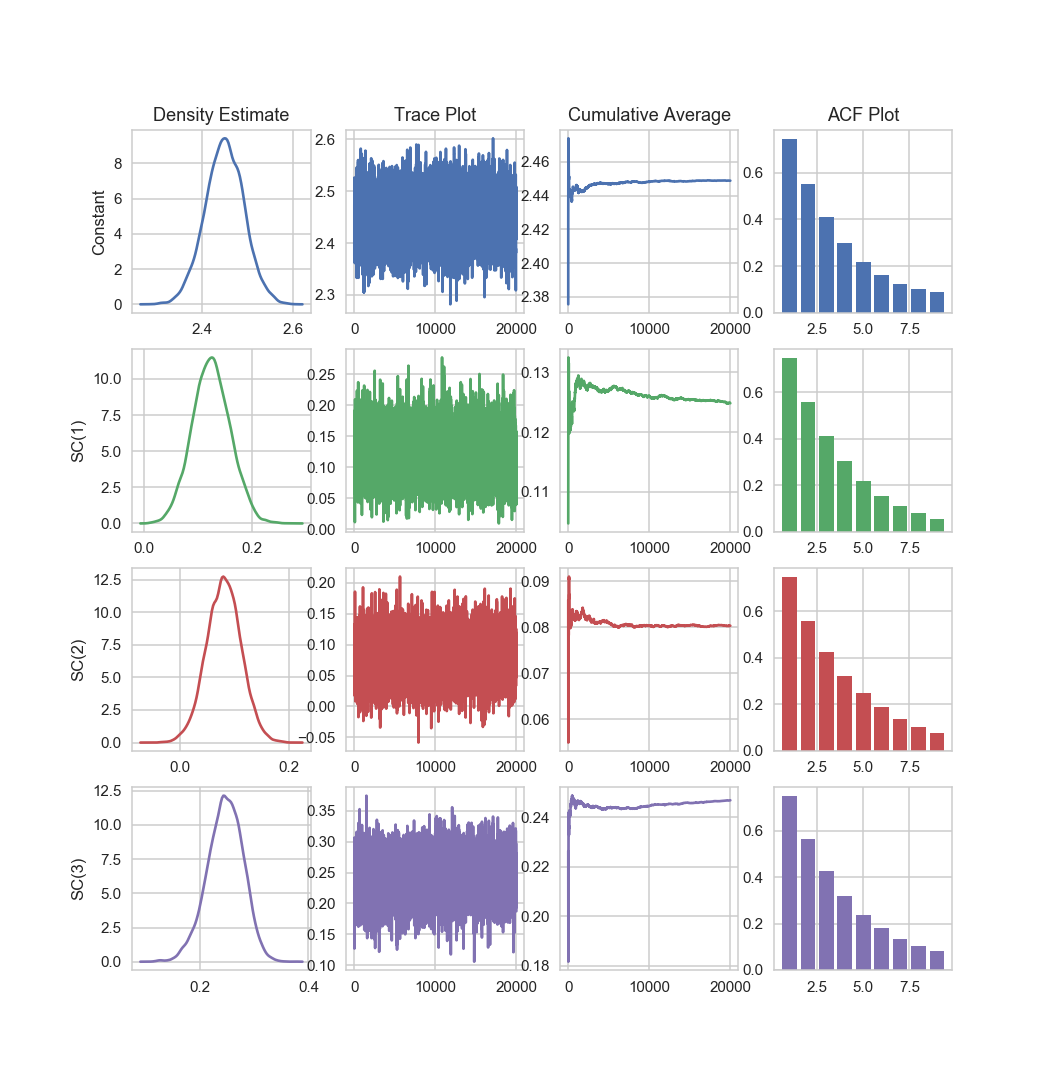

PoissonGAS (0,0,3)                                                                                        
======================================================= ==================================================
Dependent Variable: Series                              Method: Metropolis Hastings                       
Start Date: 3                                           Unnormalized Log Posterior: -514.6039             
End Date: 101                                           AIC: 1037.20777132                                
Number of observations: 99                              BIC: 1047.58825072                                
Latent Variable                          Median             Mean               95% Credibility Interval 
======================================== ================== ================== =========================
Constant                                 2.4492             2.4489             (2.3775 | 2.5182)        
SC(1)                                    0.

In [14]:
GASresults = best_GAS_model.fit(method='M-H', map_start=True, record_elbo=True, nsims=20000)
best_GAS_model.latent_variables.trace_plot(figsize=(9.7, 10))
GASresults.summary(transformed=False)

#### Plot fit to volatility and forecast for a year

<IPython.core.display.Javascript object>


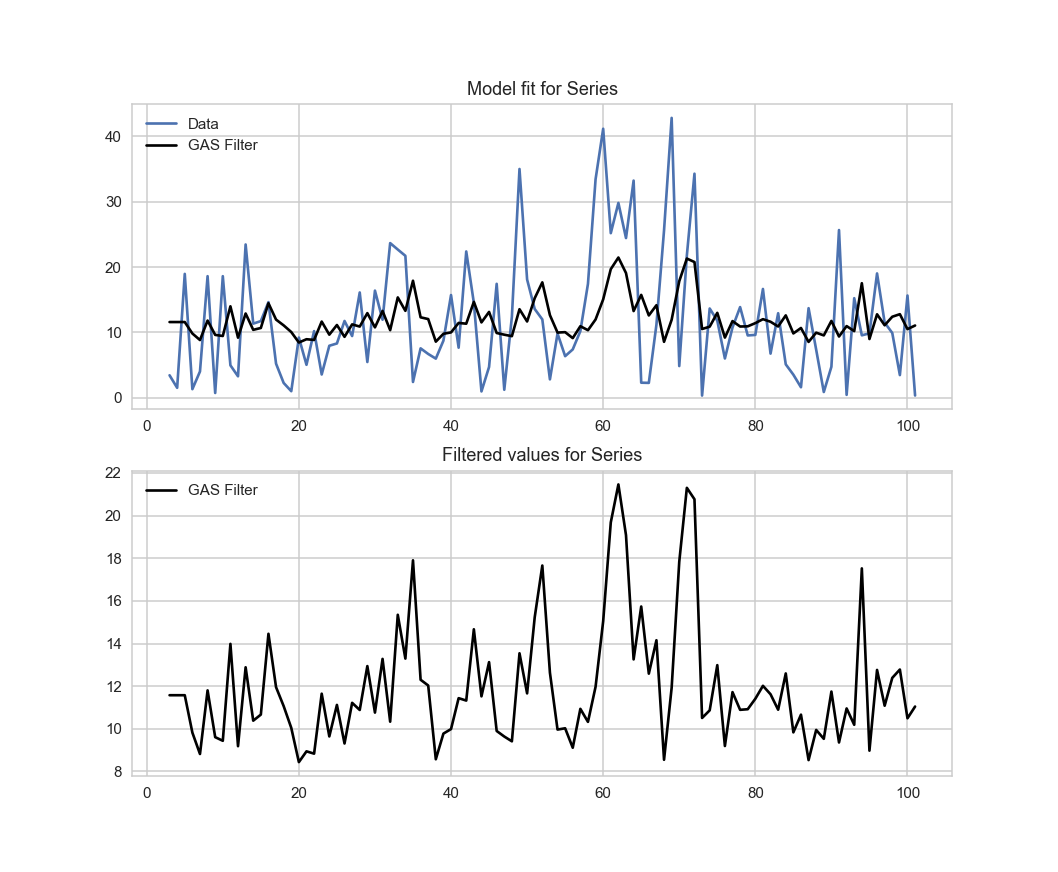

<IPython.core.display.Javascript object>


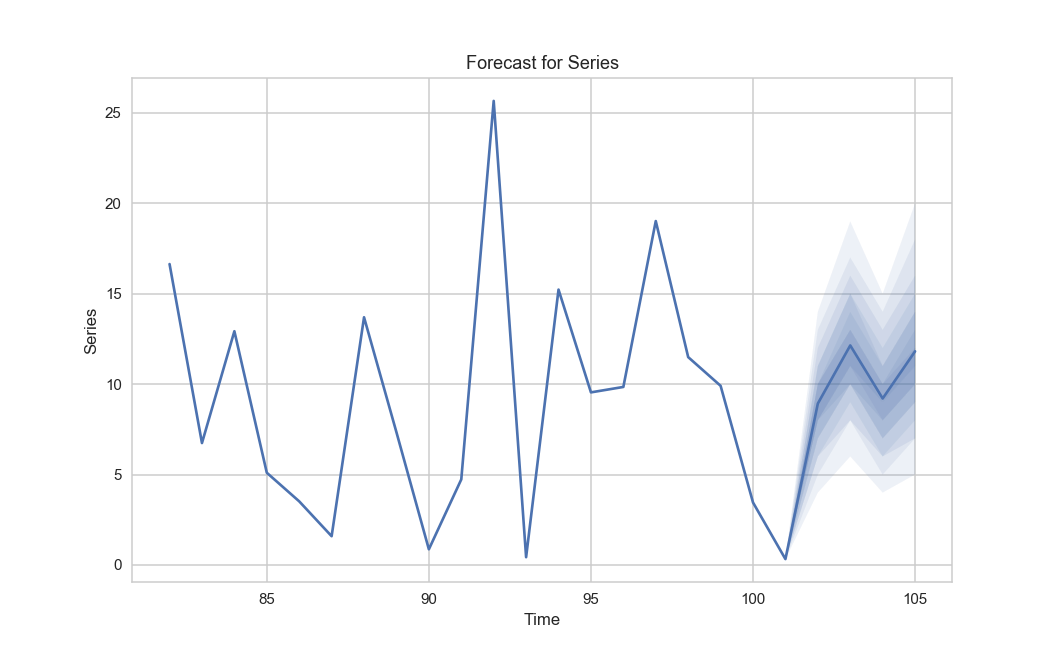

In [15]:
best_GAS_model.plot_fit(figsize=(9.7, 8))
best_GAS_model.plot_predict(h=4, figsize=(9.7, 6))
children = plt.gca().get_children() 
_ = [child.set_facecolor('C0') for child in children if isinstance(child, PolyCollection)]

### ... and on the returns
#### Set up lag ranges and scan through all models to find the one with minimal BIC

In [16]:
maximumlag = 4  # Up to which lag-order should we test models?

timeseries = returns.values
drop_first = lambda lag_combi: timeseries[maximumlag - max(lag_combi.values()):]
lag_ranges = {'ar': range(maximumlag+1),
              'sc': range(maximumlag+1)}
lag_combis = (dict(zip(lag_ranges.keys(), values)) for values in product(*lag_ranges.values()))
GAS_models = (pf.GAS(drop_first(lags), **lags, family=pf.t()) for lags in lag_combis)

best_GAS_model = best_of(GAS_models)
best_GAS_model.fit().summary(transformed=False)

tGAS (3,0,4)                                                                                              
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 4                                           Log Likelihood: -381.1314                         
End Date: 102                                           AIC: 782.2628                                     
Number of observations: 99                              BIC: 808.214                                      
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.076     0.0025     -30.1634 0.0      (-0.081 | -0.0711)       
AR(1)                                

#### Perform Black Box Variational Inference and check its convergence
Consider increasing the number of iterations if the you are not happy with what you see

10% done : ELBO is -421.25750273, p(y,z) is -399.774820647, q(z) is 21.4826820824
20% done : ELBO is -420.771005763, p(y,z) is -399.31006962, q(z) is 21.4609361427
30% done : ELBO is -420.266345246, p(y,z) is -398.79901919, q(z) is 21.4673260563
40% done : ELBO is -418.40572321, p(y,z) is -396.967528835, q(z) is 21.4381943752
50% done : ELBO is -419.134093347, p(y,z) is -397.677324639, q(z) is 21.4567687077
60% done : ELBO is -418.065356236, p(y,z) is -396.739964905, q(z) is 21.3253913311
70% done : ELBO is -418.667495367, p(y,z) is -397.305626056, q(z) is 21.3618693111
80% done : ELBO is -418.189427812, p(y,z) is -396.871408791, q(z) is 21.3180190206
90% done : ELBO is -417.981743026, p(y,z) is -396.702001779, q(z) is 21.2797412471
100% done : ELBO is -416.998625058, p(y,z) is -395.713510756, q(z) is 21.2851143022

Final model ELBO is -417.445777152


<IPython.core.display.Javascript object>


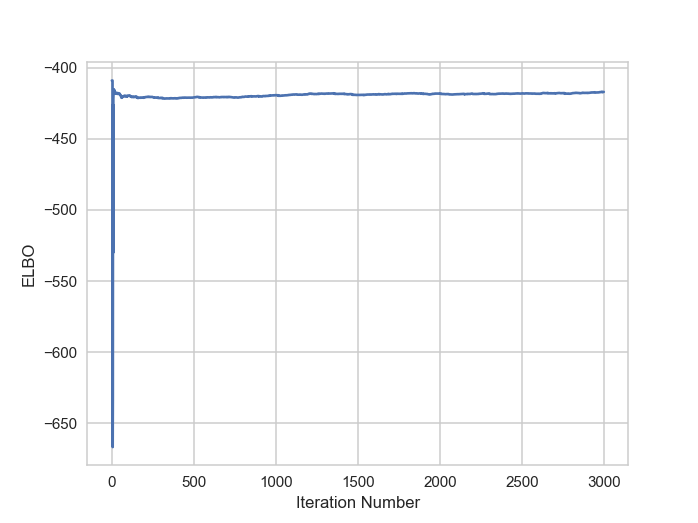

tGAS (3,0,4)                                                                                              
======================================================= ==================================================
Dependent Variable: Series                              Method: BBVI                                      
Start Date: 4                                           Unnormalized Log Posterior: -396.394              
End Date: 102                                           AIC: 812.788089372                                
Number of observations: 99                              BIC: 838.739287874                                
Latent Variable                          Median             Mean               95% Credibility Interval 
======================================== ================== ================== =========================
Constant                                 0.6568             0.6565             (0.5703 | 0.7435)        
AR(1)                                    0.

In [17]:
GASresults = best_GAS_model.fit(method='BBVI', map_start=True, record_elbo=True, iterations=3000)

fig, ax = plt.subplots()
ax.plot(GASresults.elbo_records)
ax.set_xlabel('Iteration Number')
ax.set_ylabel('ELBO')

GASresults.summary(transformed=False)

#### Plot fit to returns and forecast for a year

<IPython.core.display.Javascript object>


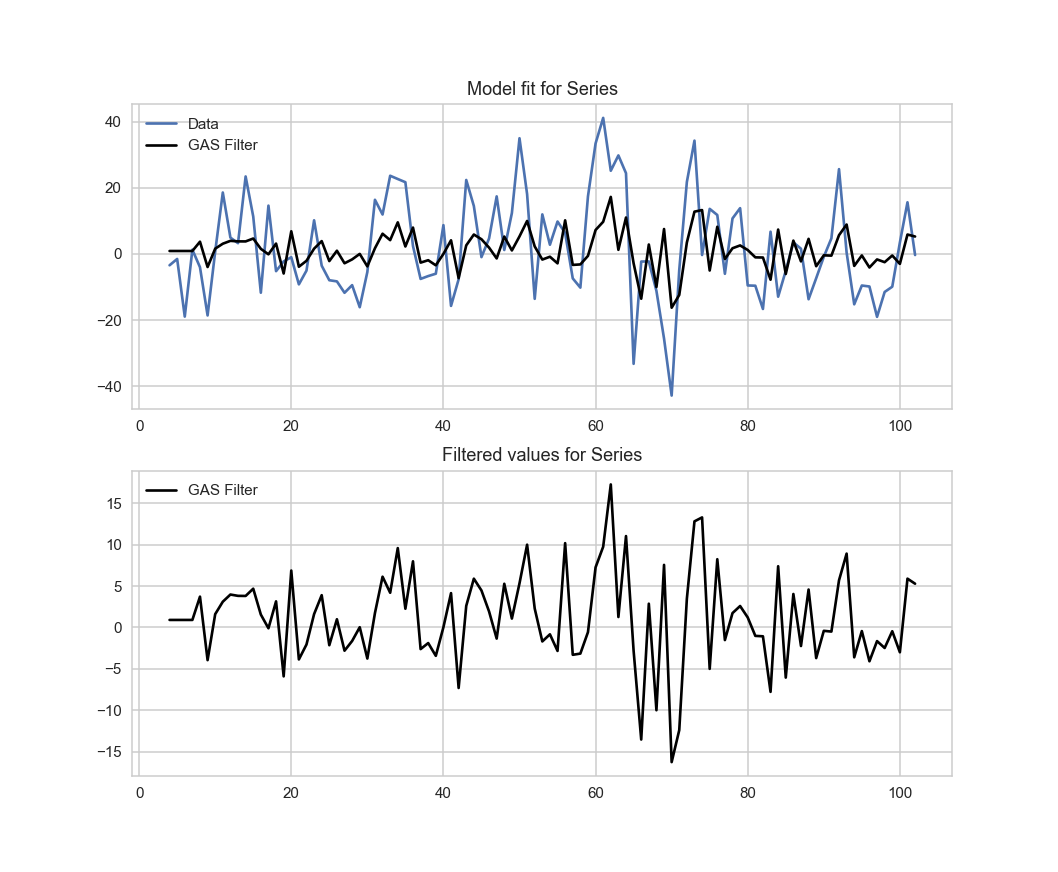

<IPython.core.display.Javascript object>


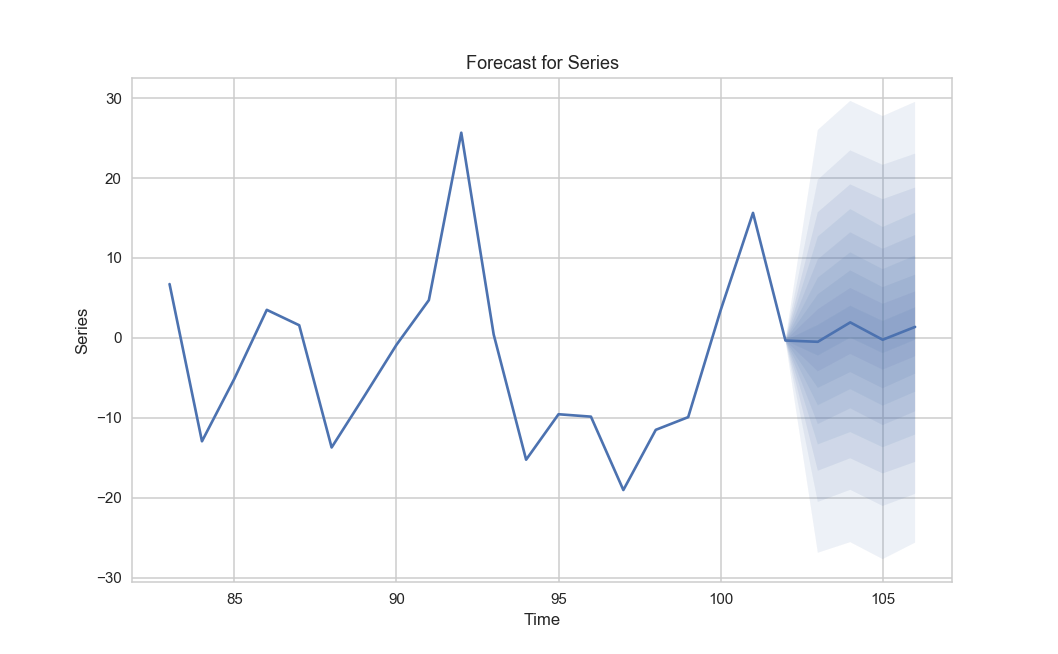

In [18]:
best_GAS_model.plot_fit(figsize=(9.7, 8))
best_GAS_model.plot_predict(h=4, figsize=(9.7, 6))
children = plt.gca().get_children() 
_ = [child.set_facecolor('C0') for child in children if isinstance(child, PolyCollection)]

### GAS local-level model on the volatility
#### Find maximum-likelihood parameters first 

In [8]:
timeseries = returns.abs().values
GASLLmodel = pf.GASLLEV(timeseries, pf.Poisson())
GASLLEVres = GASLLmodel.fit()
GASLLEVres.summary(transformed=False)

Poisson GAS LLM                                                                                           
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 1                                           Log Likelihood: -565.8468                         
End Date: 102                                           AIC: 1133.6937                                    
Number of observations: 102                             BIC: 1136.3187                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
SC(1)                                    0.1734     0.0204     8.5027   0.0      (0.1334 | 0.2134)        


#### Sample posterior probability with MCMC
Consider increasing the number of simulated steps if the results are not converged

Acceptance rate of Metropolis-Hastings is 0.45145
Acceptance rate of Metropolis-Hastings is 0.36685

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.3616


<IPython.core.display.Javascript object>


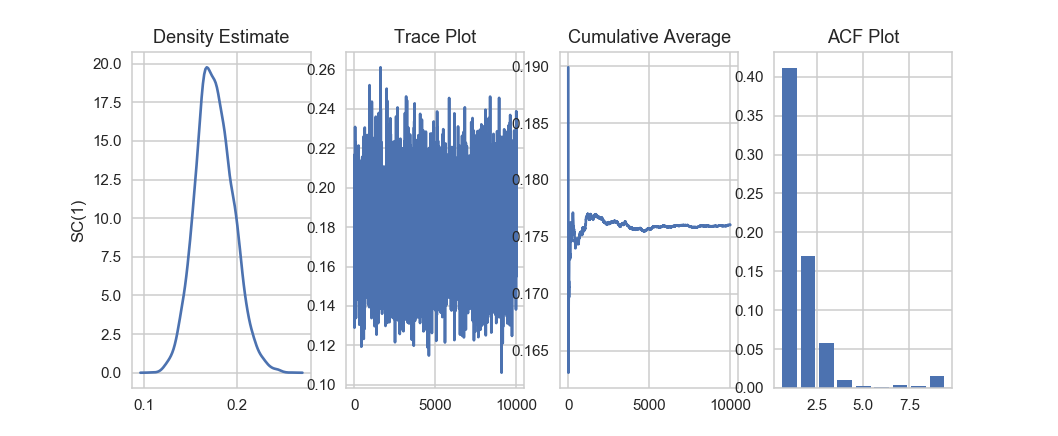

Poisson GAS LLM                                                                                           
======================================================= ==================================================
Dependent Variable: Series                              Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: -565.224              
End Date: 102                                           AIC: 1132.44802343                                
Number of observations: 102                             BIC: 1135.07299625                                
Latent Variable                          Median             Mean               95% Credibility Interval 
======================================== ================== ================== =========================
SC(1)                                    0.175              0.1761             (0.1441 | 0.2102)        


In [9]:
GASLLEVres = GASLLmodel.fit(method='M-H', map_start=True, nsims=10000)
GASLLmodel.latent_variables.trace_plot(figsize=(9.7, 4))
GASLLEVres.summary(transformed=False)

#### Plot fit to volatility and forecast for a year

<IPython.core.display.Javascript object>


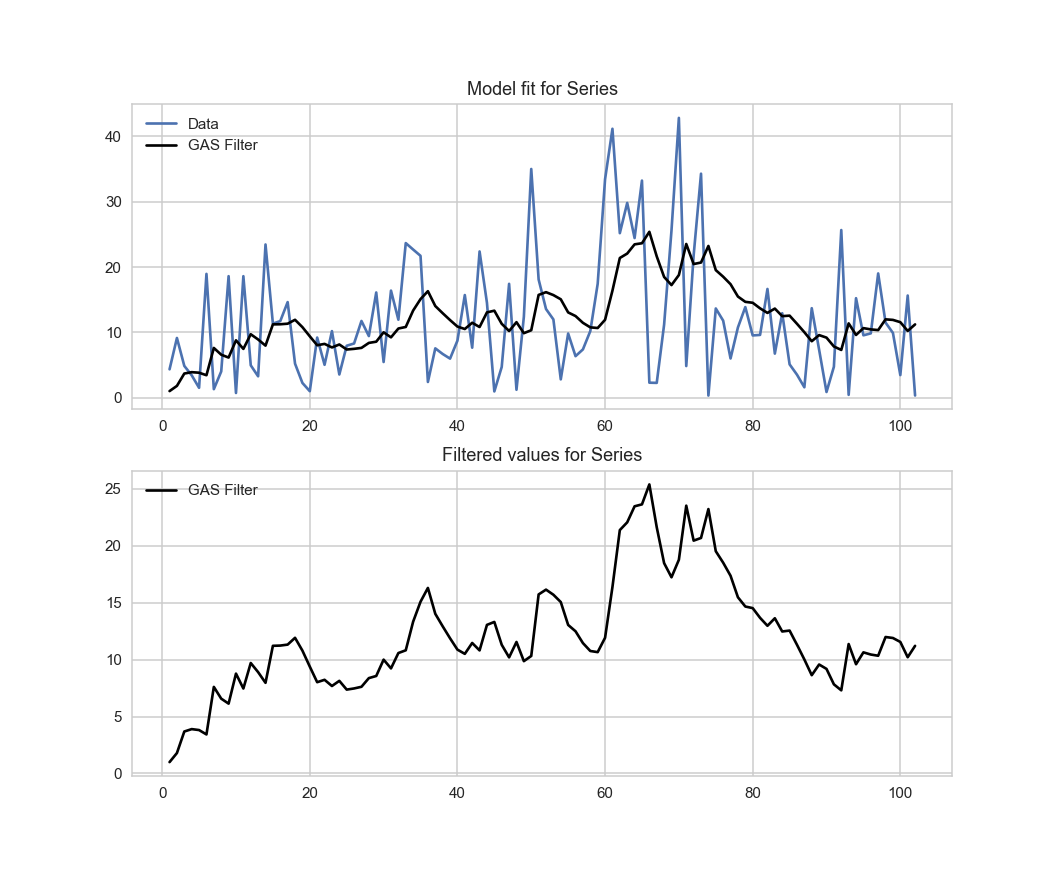

<IPython.core.display.Javascript object>


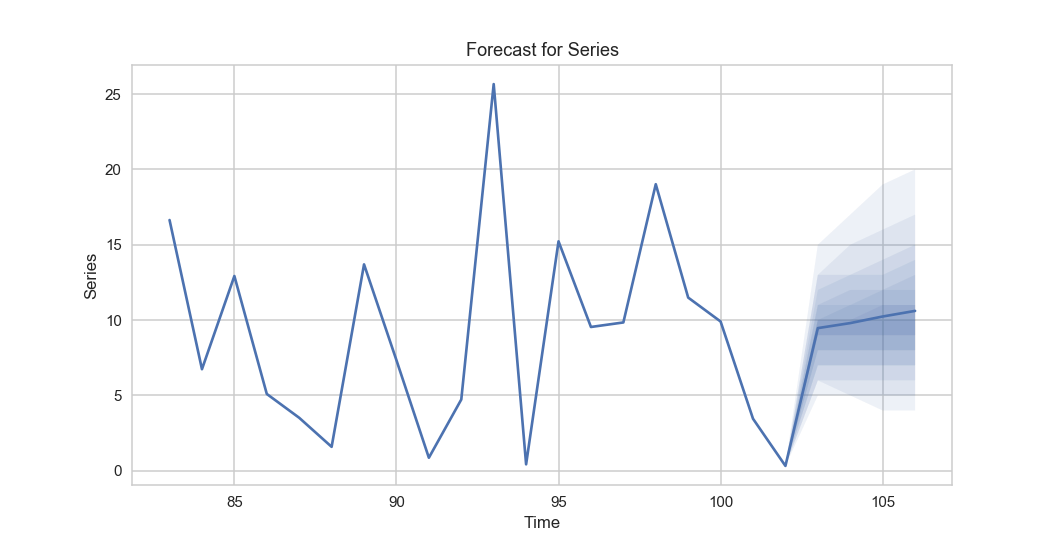

In [10]:
GASLLmodel.plot_fit(figsize=(9.7, 8))
GASLLmodel.plot_predict(h=4, figsize=(9.7, 5))
children = plt.gca().get_children() 
_ = [child.set_facecolor('C0') for child in children if isinstance(child, PolyCollection)]

### GP-NARX models on the returns ...
#### Set up parameter ranges and scan through all models to find the one with minimal BIC
Note that not all kernels always lead to well-conditioned models

In [21]:
max_lag = 3  # Up to which lag-order should we test models?

tseries = returns.values
without = lambda ar: tseries[max_lag - ar:]
ar_lags = range(1, max_lag+1)
kernels = (pf.SquaredExponential(), pf.OrnsteinUhlenbeck(), pf.Periodic())  # maybe also pf.RationalQuadratic()
GPNARXs = (pf.GPNARX(without(lag), lag, kernel) for lag in ar_lags for kernel in kernels)

best_GPNARX_model = best_of(GPNARXs)
nkernel = str(best_GPNARX_model.kernel).split('.')[3].split(' ')[0]
results = best_GPNARX_model.fit()
results.summary(transformed=False)
print('BEST KERNEL IS', nkernel)

GPNARX(3)                                                                                                 
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 3                                           Log Likelihood: -134.1207                         
End Date: 102                                           AIC: 274.2415                                     
Number of observations: 100                             BIC: 282.057                                      
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
log(Noise Sigma^2)                       -0.0972    1.6957     0.5351   0.5926   (-2.4163 | 4.231)        
log(l)                               

#### Plot fit to returns and forecast for a year

<IPython.core.display.Javascript object>


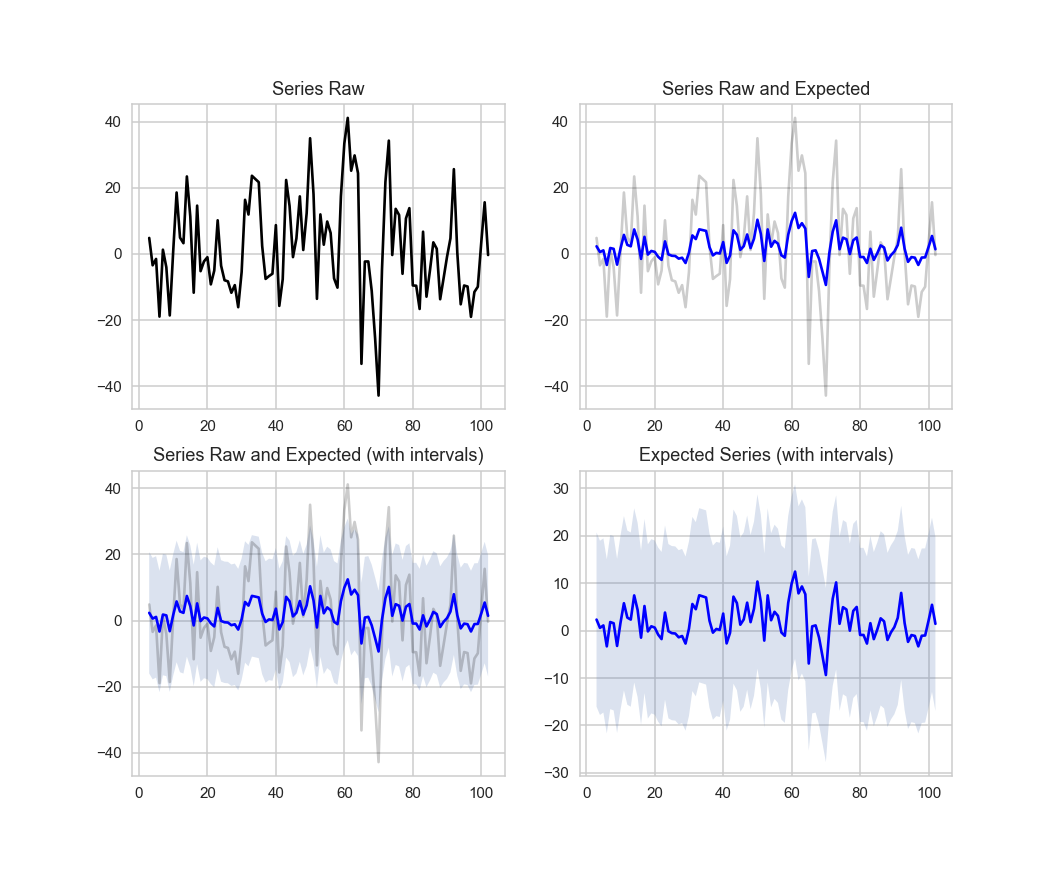

<IPython.core.display.Javascript object>


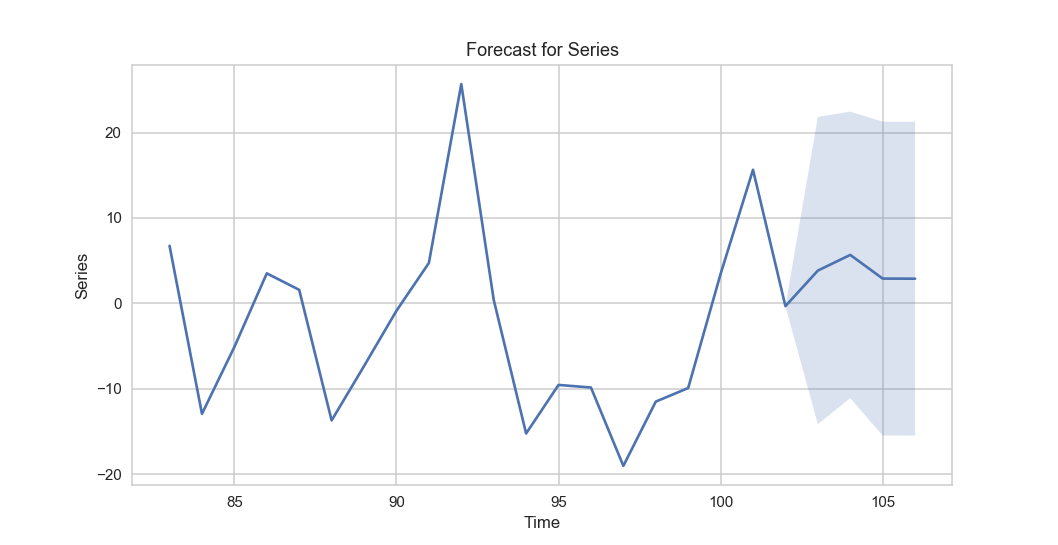

In [22]:
best_GPNARX_model.plot_fit(figsize=(9.7, 8))
best_GPNARX_model.plot_predict(h=4, figsize=(9.7, 5))
children = plt.gca().get_children() 
_ = [child.set_facecolor('C0') for child in children if isinstance(child, PolyCollection)]

### VAR model
#### Set up parameter ranges and scan through all models to find the one with minimal BIC

In [23]:
maximumlag = 12  # Up to which lag-order should we test models?

timeseries = 100 * raw_data.loc[:, 'Energy':'Livestock'].resample('BQ').mean().pct_change(1).dropna()
drop_first = lambda ar_lag: timeseries.iloc[maximumlag - ar_lag:, :]
lag_orders = range(1, maximumlag+1)
VAR_models = (pf.VAR(drop_first(lag), lag) for lag in lag_orders)

min_bic, best_VAR_model = min((model.fit().bic, model) for model in VAR_models)
best_VAR_model.fit().summary(transformed=False)

VAR(1)                                                                                                    
======================================================= ==================================================
Dependent Variable: Energy,Precious Metals,Industrial M Method: OLS                                       
Start Date: 1994-06-30 00:00:00                         Log Likelihood: -1554.1606                        
End Date: 2016-12-30 00:00:00                           AIC: 3198.3212                                    
Number of observations: 91                              BIC: 3311.3098                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Energy Constant                          0.2531     1.3182     0.192    0.8477   (-2.3306 | 2.8369)       
Energy AR(1)                         

#### Perform Black Box Variational Inference and check its convergence
Consider increasing the number of iterations if the you are not happy with what you see

10% done : ELBO is -1659.57081159, p(y,z) is -1566.5463371, q(z) is 93.0244744951
20% done : ELBO is -1655.74515809, p(y,z) is -1563.06477265, q(z) is 92.6803854487
30% done : ELBO is -1655.39471315, p(y,z) is -1562.82851649, q(z) is 92.5661966628
40% done : ELBO is -1655.0124845, p(y,z) is -1562.70912362, q(z) is 92.30336088
50% done : ELBO is -1652.60083575, p(y,z) is -1560.47978453, q(z) is 92.1210512193
60% done : ELBO is -1652.12451824, p(y,z) is -1560.16384086, q(z) is 91.9606773795
70% done : ELBO is -1651.43050913, p(y,z) is -1559.50650062, q(z) is 91.9240085163
80% done : ELBO is -1648.14265612, p(y,z) is -1556.50578943, q(z) is 91.6368666905
90% done : ELBO is -1646.77859737, p(y,z) is -1555.27048454, q(z) is 91.5081128252
100% done : ELBO is -1647.67306054, p(y,z) is -1556.3042748, q(z) is 91.3687857479

Final model ELBO is -1646.08446936


<IPython.core.display.Javascript object>


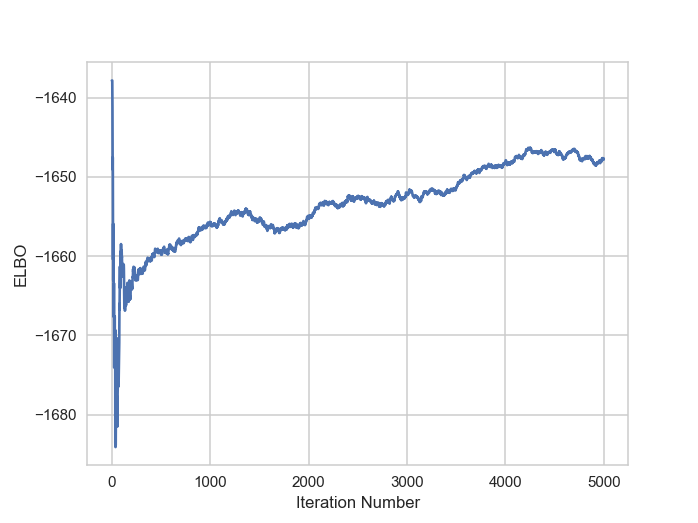

VAR(1)                                                                                                    
======================================================= ==================================================
Dependent Variable: Energy,Precious Metals,Industrial M Method: BBVI                                      
Start Date: 1994-06-30 00:00:00                         Unnormalized Log Posterior: -1555.8503            
End Date: 2016-12-30 00:00:00                           AIC: 3201.7005531                                 
Number of observations: 91                              BIC: 3314.6892309                                 
Latent Variable                          Median             Mean               95% Credibility Interval 
======================================== ================== ================== =========================
Energy Constant                          0.538              0.5381             (0.4375 | 0.6389)        
Energy AR(1)                             0.

In [24]:
VARresults = best_VAR_model.fit(method='BBVI', map_start=True, record_elbo=True, iterations=5000)

fig, ax = plt.subplots()
ax.plot(VARresults.elbo_records)
ax.set_xlabel('Iteration Number')
ax.set_ylabel('ELBO')

VARresults.summary(transformed=False)

#### Plot fit to returns and forecast for a year

<IPython.core.display.Javascript object>


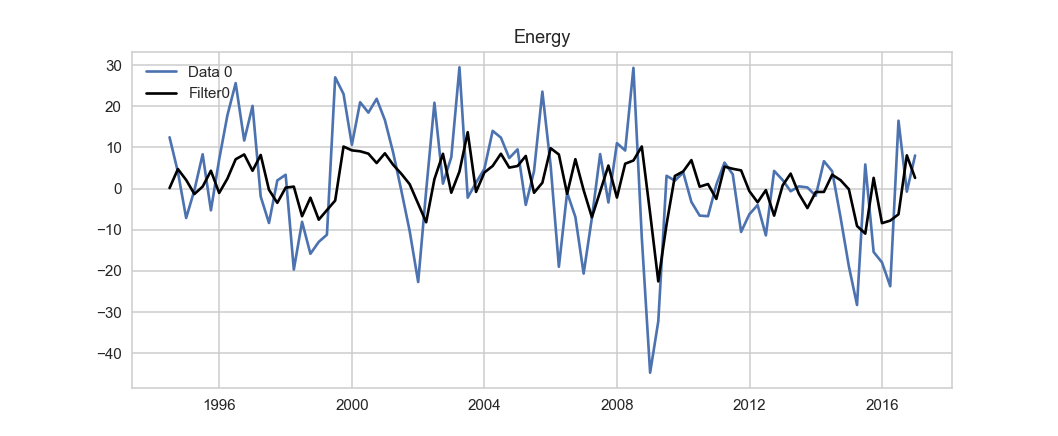

<IPython.core.display.Javascript object>


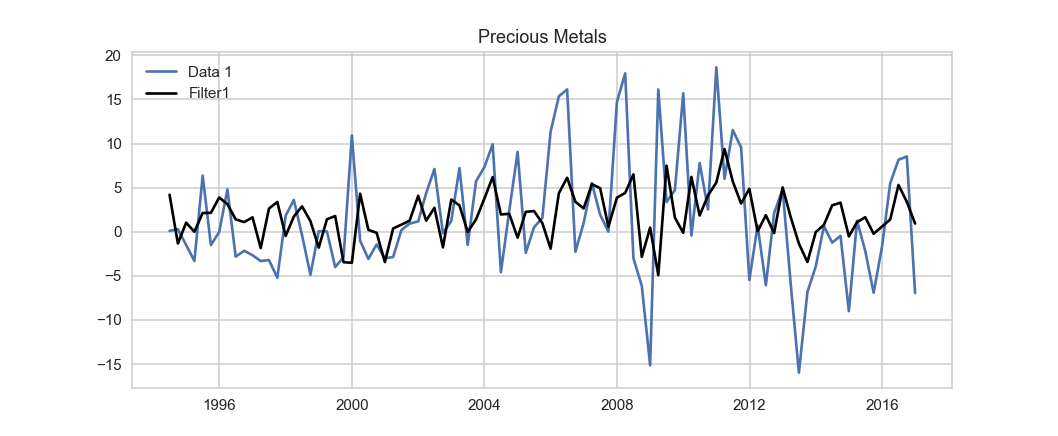

<IPython.core.display.Javascript object>


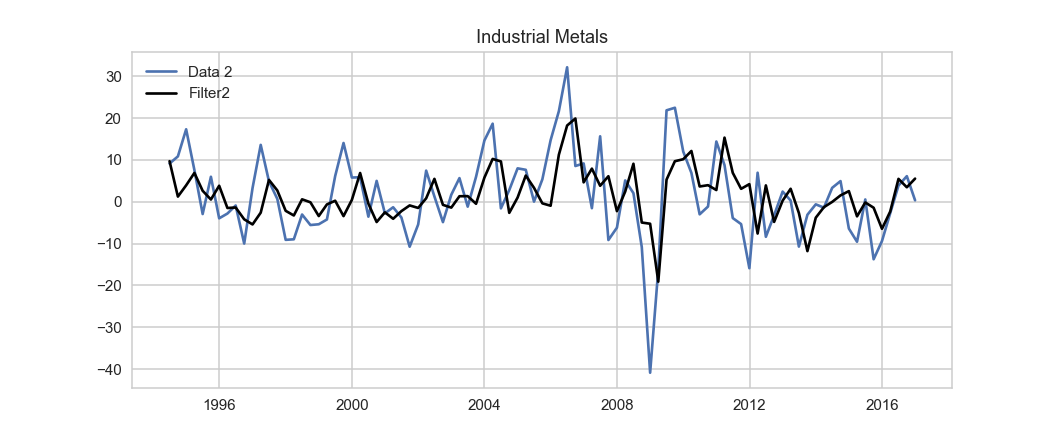

<IPython.core.display.Javascript object>


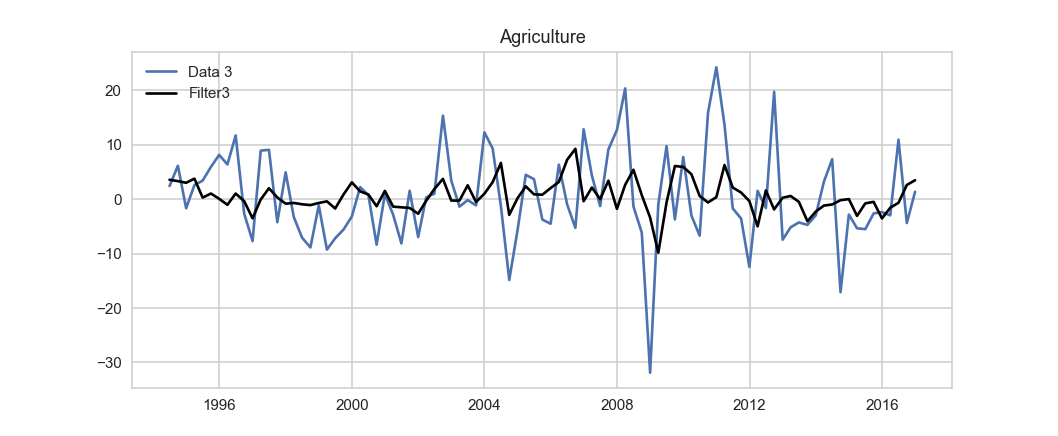

<IPython.core.display.Javascript object>


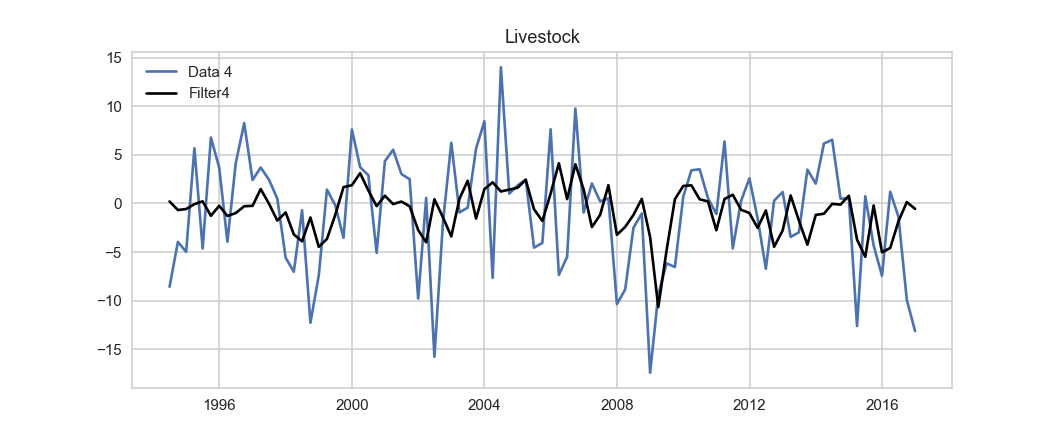

<IPython.core.display.Javascript object>


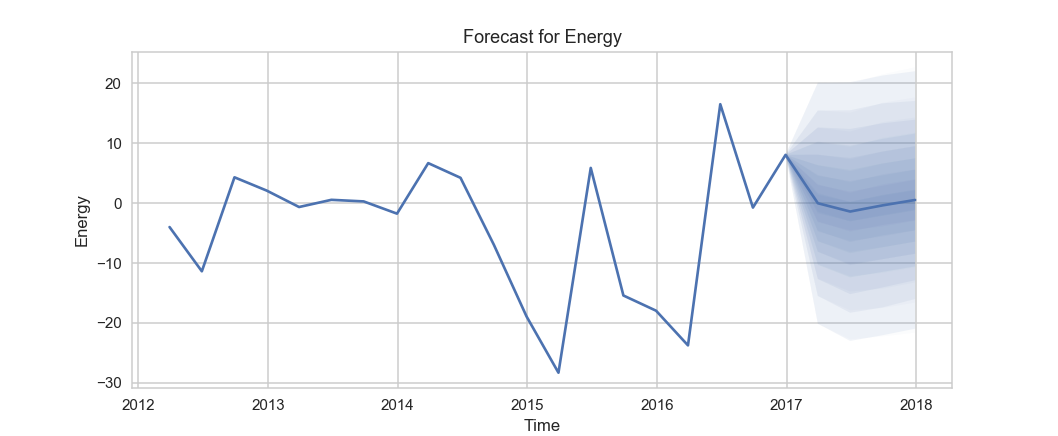

<IPython.core.display.Javascript object>


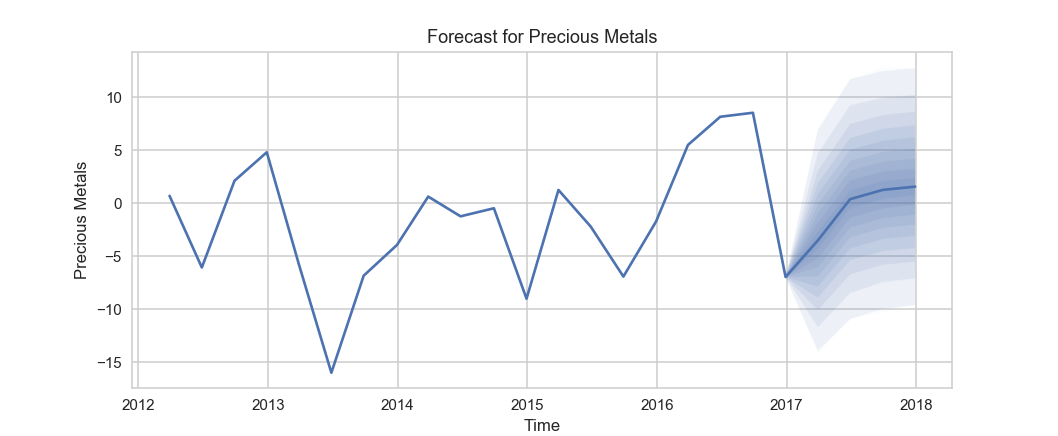

<IPython.core.display.Javascript object>


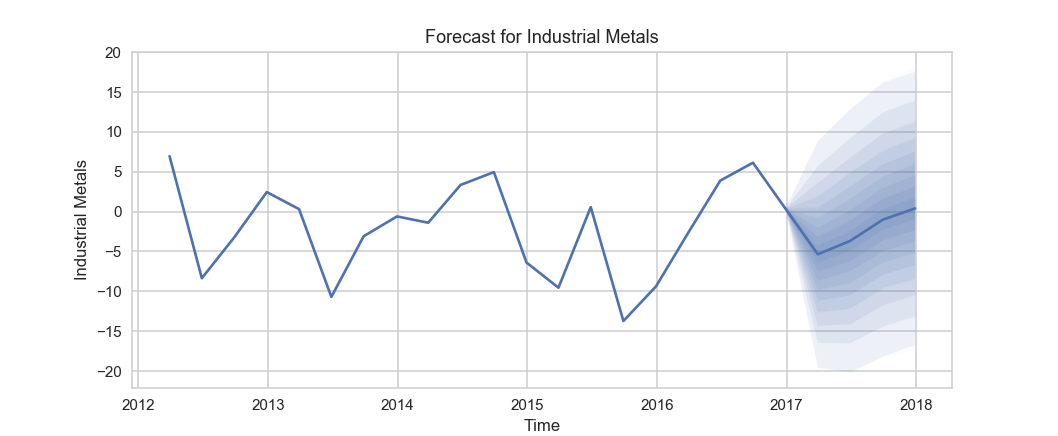

<IPython.core.display.Javascript object>


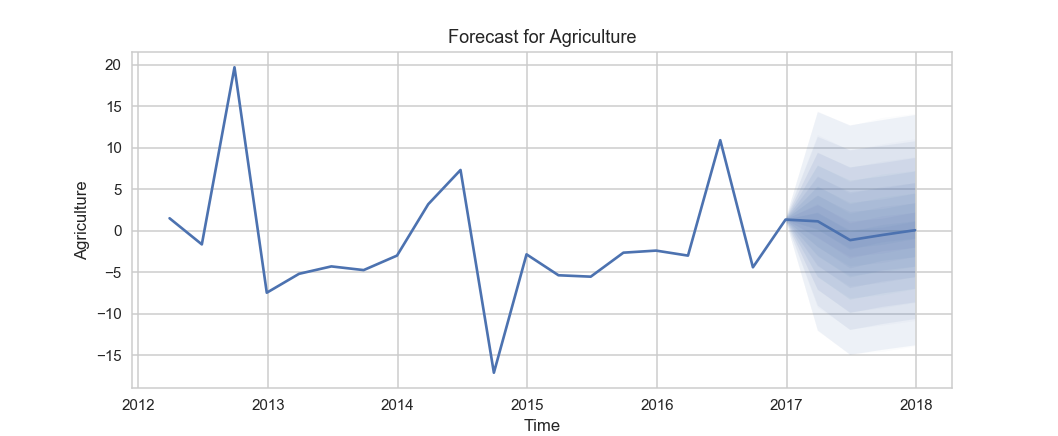

<IPython.core.display.Javascript object>


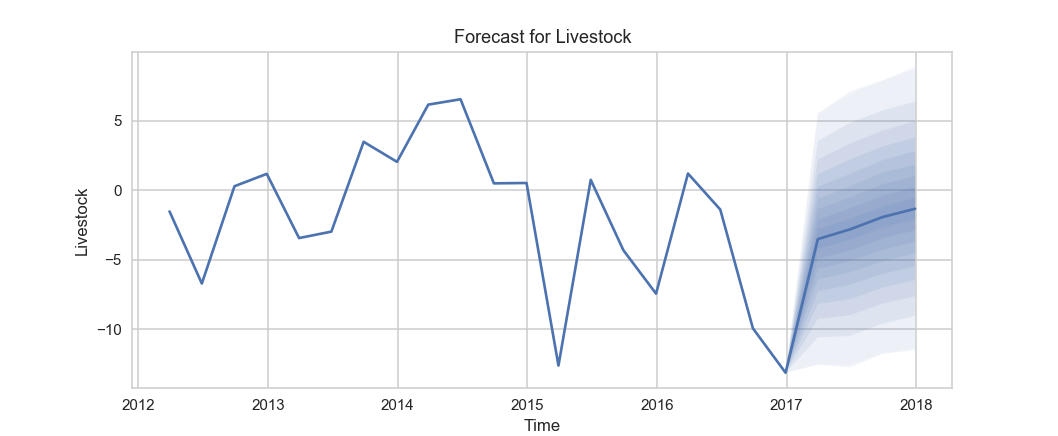

In [25]:
best_VAR_model.plot_fit(figsize=(9.7, 4))
best_VAR_model.plot_predict(h=4, figsize=(9.7, 4))
for figure in map(plt.figure, plt.get_fignums()[-5:]):
    children = plt.gca().get_children()
    _ = [child.set_facecolor('C0') for child in children if isinstance(child, PolyCollection)]

## Concluding remarks

While there are yet more models available in the `PyFlux` package, it does not make sense to apply them all on the financial data at hand. In partiuclar, quarterly returns have neither a "local level" nor "local linear trend". Likewise, the raw index the data is not well described by such models because the volatility is not exactly constant. Lastly, the nonlinear local level models available in `PyFlux` do not describe the volatility well for some reason. So, while a fascinating class of models, they are not included here.